In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datasets import get_datasets, get_shiller
import matplotlib.pyplot as plt
import random

time_horizon = 40

data = get_datasets()
data['returns_with_dividends'] = data['simple_return'] + data['dividend_return']

[*********************100%***********************]  1 of 1 completed


Durbin-Watson statistic: 1.4118877830698404


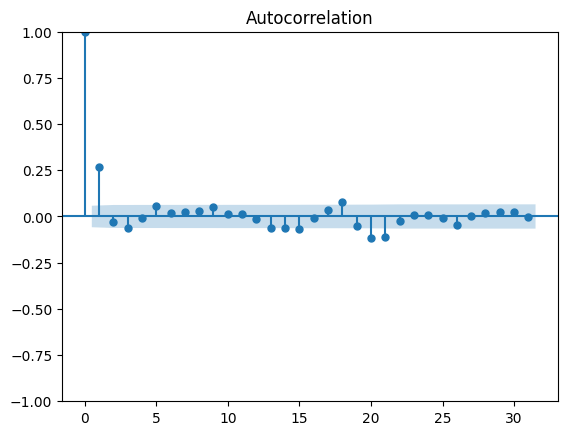

KeyError: 'lbvalue'

In [180]:
import pandas as pd
from statsmodels.stats.stattools import durbin_watson

# Assume you have a DataFrame `df` with a column "dividend_returns" for the simple returns
dividend_returns = data['returns_with_dividends']

# Apply the Durbin-Watson test
dw_result = durbin_watson(dividend_returns)

print("Durbin-Watson statistic:", dw_result)


import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming dividend_returns is your Series
plot_acf(dividend_returns)
plt.show()


from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test
lb_result = acorr_ljungbox(dividend_returns, lags=[10])

print("Ljung-Box test statistic:", lb_result['lbvalue'])
print("p-value:", lb_result['pvalue'])



In [ ]:
# Define the investment horizon
time_horizon = 40

# Define the horizons and the number of portfolios
horizons = np.arange(1, time_horizon+1, 1)
n_portfolios = len(data) - (time_horizon * 12) + 1

cum_risk_free_returns_distributions = np.zeros((len(horizons), n_portfolios))
cum_dividends_returns_distributions = np.zeros((len(horizons), n_portfolios))
starting_dates = []

# Loop through each investment horizon
# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):
    # Calculate the number of years in the specified time horizon
    years_in_horizon = horizon

    # Calculate the number of months in the specified time horizon
    months_in_horizon = horizon * 12

    # Loop through each portfolio and calculate the cumulative returns
    for i in range(n_portfolios):
        start_idx = i
        end_idx = start_idx + months_in_horizon

        risk_free_returns = data.loc[start_idx:end_idx-1, 'returns_rf'].values
        dividends_returns = data.loc[start_idx:end_idx-1, 'returns_with_dividends'].values

        cum_risk_free_returns_portfolios = np.prod(1 + risk_free_returns) - 1
        cum_dividends_returns_portfolios = np.prod(1 + dividends_returns) - 1

        # Convert the cumulative returns into annualized returns
        annualized_risk_free_returns_portfolios = (1 + cum_risk_free_returns_portfolios)**(1/years_in_horizon) - 1
        annualized_dividends_returns_portfolios = (1 + cum_dividends_returns_portfolios)**(1/years_in_horizon) - 1

        cum_risk_free_returns_distributions[h_idx, i] = annualized_risk_free_returns_portfolios
        cum_dividends_returns_distributions[h_idx, i] = annualized_dividends_returns_portfolios


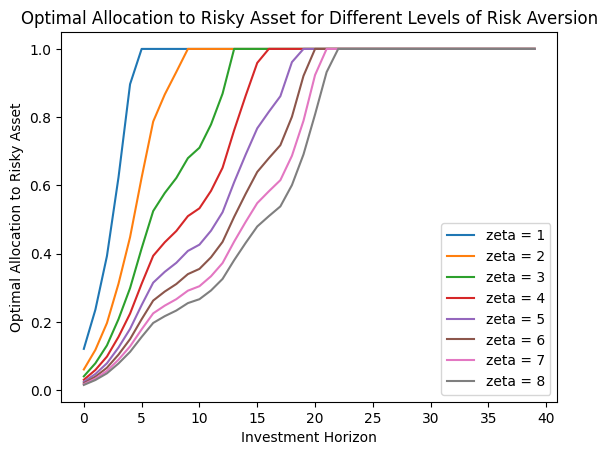

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns.

    Parameters:
    - risky_returns: A numpy array of risky asset returns
    - risk_free_returns: A numpy array of risk-free asset returns
    - zeta: The degree of risk aversion
    - periods_in_year: The number of periods in a year (12 for monthly returns, 250 for daily returns)

    Returns:
    - w: The optimal allocation to the risky asset
    """
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)
        
    # Clip allocation to [0,1]
    w = np.clip(w, 0, 1)

    return w

# load your return data
# cum_dividends_returns_distributions = ...
# cum_risk_free_returns_distributions = ...

# calculate the optimal allocation for each investment horizon
zetas = range(1, 9)
allocations = []
for zeta in zetas:
    allocations_zeta = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        w = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta)
        allocations_zeta.append(w)
    allocations.append(allocations_zeta)

# create plot
for i, zeta in enumerate(zetas):
    plt.plot(allocations[i], label=f'zeta = {zeta}')
plt.legend()
plt.xlabel('Investment Horizon')
plt.ylabel('Optimal Allocation to Risky Asset')
plt.title('Optimal Allocation to Risky Asset for Different Levels of Risk Aversion')
plt.show()


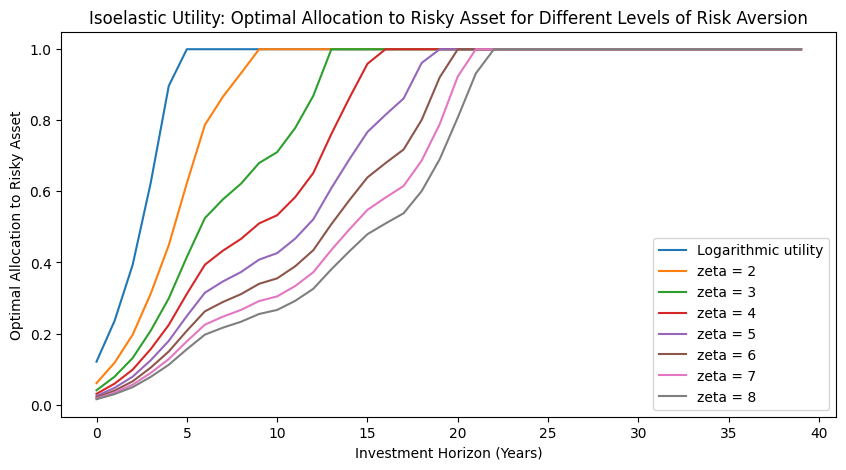

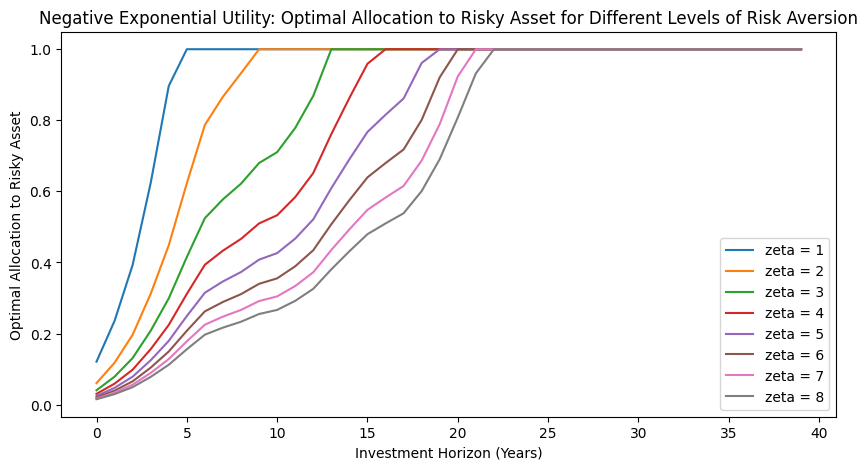

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns.

    Parameters:
    - risky_returns: A numpy array of risky asset returns
    - risk_free_returns: A numpy array of risk-free asset returns
    - zeta: The degree of risk aversion
    - periods_in_year: The number of periods in a year (12 for monthly returns, 250 for daily returns)

    Returns:
    - w: The optimal allocation to the risky asset
    """
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    # Clip allocation to [0,1]
    w = np.clip(w, 0, 1)

    return w

# Isoelastic and Logarithmic utility plot
zetas = range(1, 9)  # Include zeta=1 for logarithmic utility
allocations = []
for zeta in zetas:
    allocations_zeta = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        w = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta)
        allocations_zeta.append(w)
    allocations.append(allocations_zeta)

labels = ['Logarithmic utility'] + [f'zeta = {zeta}' for zeta in zetas[1:]]
plt.figure(figsize=(10, 5))
for i, label in enumerate(labels):
    plt.plot( allocations[i], label=label)
plt.legend()
  # Show every fifth year on the x-axis
plt.xlabel('Investment Horizon (Years)')
plt.ylabel('Optimal Allocation to Risky Asset')
plt.title('Isoelastic Utility: Optimal Allocation to Risky Asset for Different Levels of Risk Aversion')
plt.show()

# Negative Exponential utility plot
def calculate_exponential_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation
    w = (mu - rf) / (zeta * sigma**2)  # Negative exponential utility
    w = np.clip(w, 0, 1)  # Clip allocation to [0,1]
    return w

zetas_exp = range(1, 9)  # For negative exponential utility
allocations_exp = []
for zeta in zetas_exp:
    allocations_zeta = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        w = calculate_exponential_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta)
        allocations_zeta.append(w)
    allocations_exp.append(allocations_zeta)

plt.figure(figsize=(10, 5))
for zeta, allocation in zip(zetas_exp, allocations_exp):
    plt.plot( allocation, label=f'zeta = {zeta}')
plt.legend()
 # Show every fifth year on the x-axis
plt.xlabel('Investment Horizon (Years)')
plt.ylabel('Optimal Allocation to Risky Asset')
plt.title('Negative Exponential Utility: Optimal Allocation to Risky Asset for Different Levels of Risk Aversion')
plt.show()


In [ ]:
import numpy as np

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, i, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns.

    Parameters:
    - risky_returns: A numpy array of risky asset returns
    - risk_free_returns: A numpy array of risk-free asset returns
    - zeta: The degree of risk aversion
    - i: Index of the current observation
    - periods_in_year: The number of periods in a year (12 for monthly returns, 250 for daily returns)

    Returns:
    - w: The optimal allocation to the risky asset
    - p_values: List of p-values for horizon = 5 and 10
    """

    # Original calculation
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    # Calculate p-value for horizon = 5
    horizon_risky_returns_5 = cum_dividends_returns_distributions[4]  # Adjust index to access the correct element
    horizon_rf_returns_5 = cum_risk_free_returns_distributions[4]  # Adjust index to access the correct element
    horizon_w_5 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_5, horizon_rf_returns_5, zeta, periods_in_year)
    diff_weights_5 = horizon_w_5 - w  # Calculate difference in weights
    p_value_5 = float(diff_weights_5 < 0)  # Calculate p-value for horizon = 5

    # Calculate p-value for horizon = 10
    horizon_risky_returns_10 = cum_dividends_returns_distributions[9]  # Adjust index to access the correct element
    horizon_rf_returns_10 = cum_risk_free_returns_distributions[9]  # Adjust index to access the correct element
    horizon_w_10 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_10, horizon_rf_returns_10, zeta, periods_in_year)
    diff_weights_10 = horizon_w_10 - w  # Calculate difference in weights
    p_value_10 = float(diff_weights_10 < 0)  # Calculate p-value for horizon = 10
    print(i,p_value_10,p_value_5)
    return w, [p_value_5, p_value_10]


def calculate_optimal_allocation_annualized_no_test(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns, without performing the horizon invariance test.

    Parameters and Returns:
    - Same as calculate_optimal_allocation_annualized()
    """
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    return w


# Isoelastic and Logarithmic utility plot
zetas = [2,4,6,8]  # Include zeta=1 for logarithmic utility
horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15]  # Define the horizons
p_value_table = []

for zeta in zetas:
    row = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        allocation, p_values = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta, i)
        row.append(np.clip(allocation,0,1)*100)
        if i == len(cum_dividends_returns_distributions)-1:
            row.extend(p_values)  # Append p-values for the last observation
    p_value_table.append(row)

# Generate LaTeX table
table = "\\begin{table}[ht]\n"
table += "\\centering\n"
table += "\\caption{Optimal Allocations and P-Values}\n"
table += "\\begin{tabular}{|c|" + "|".join(["c" for _ in range(len(horizons) + 2)]) + "|}\n"
table += "\\hline\n"
table += "Zeta & " + " & ".join([f"{h}-year" for h in horizons]) + " & P-value (1-5) & P-value (1-10) \\\\\n"
table += "\\hline\n"
for i, zeta in enumerate(zetas):
    table += f"{zeta} & "
    for j in range(len(horizons)):
        table += f"{p_value_table[i][j]:.1f}\% & "
    table += f"{p_value_table[i][-2]} & {p_value_table[i][-1]} \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\end{table}"

print(table)


0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.0 1.0
6 0.0 1.0
7 0.0 1.0
8 0.0 1.0
9 0.0 1.0
10 1.0 1.0
11 1.0 1.0
12 1.0 1.0
13 1.0 1.0
14 1.0 1.0
15 1.0 1.0
16 1.0 1.0
17 1.0 1.0
18 1.0 1.0
19 1.0 1.0
20 1.0 1.0
21 1.0 1.0
22 1.0 1.0
23 1.0 1.0
24 1.0 1.0
25 1.0 1.0
26 1.0 1.0
27 1.0 1.0
28 1.0 1.0
29 1.0 1.0
30 1.0 1.0
31 1.0 1.0
32 1.0 1.0
33 1.0 1.0
34 1.0 1.0
35 1.0 1.0
36 1.0 1.0
37 1.0 1.0
38 1.0 1.0
39 1.0 1.0
0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.0 1.0
6 0.0 1.0
7 0.0 1.0
8 0.0 1.0
9 0.0 1.0
10 1.0 1.0
11 1.0 1.0
12 1.0 1.0
13 1.0 1.0
14 1.0 1.0
15 1.0 1.0
16 1.0 1.0
17 1.0 1.0
18 1.0 1.0
19 1.0 1.0
20 1.0 1.0
21 1.0 1.0
22 1.0 1.0
23 1.0 1.0
24 1.0 1.0
25 1.0 1.0
26 1.0 1.0
27 1.0 1.0
28 1.0 1.0
29 1.0 1.0
30 1.0 1.0
31 1.0 1.0
32 1.0 1.0
33 1.0 1.0
34 1.0 1.0
35 1.0 1.0
36 1.0 1.0
37 1.0 1.0
38 1.0 1.0
39 1.0 1.0
0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.0 1.0
6 0.0 1.0
7 0.0 1.0
8 0.0 1.0
9 0.0 1.0
10 1.0 1.0
11 1.0 1.0
12 1.0 1.0
13 1.0 

In [ ]:
import numpy as np

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, i, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns.

    Parameters:
    - risky_returns: A numpy array of risky asset returns
    - risk_free_returns: A numpy array of risk-free asset returns
    - zeta: The degree of risk aversion
    - i: Index of the current observation
    - periods_in_year: The number of periods in a year (12 for monthly returns, 250 for daily returns)

    Returns:
    - w: The optimal allocation to the risky asset
    - p_values: List of p-values for horizon = 5 and 10
    """

    # Original calculation
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    # Calculate p-value for horizon = 5
    horizon_risky_returns_5 = cum_dividends_returns_distributions[4]  # Adjust index to access the correct element
    horizon_rf_returns_5 = cum_risk_free_returns_distributions[4]  # Adjust index to access the correct element
    horizon_w_5 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_5, horizon_rf_returns_5, zeta, periods_in_year)
    diff_weights_5 = horizon_w_5 - w  # Calculate difference in weights
    p_value_5 = float(diff_weights_5 < 0)  # Calculate p-value for horizon = 5

    # Calculate p-value for horizon = 10
    horizon_risky_returns_10 = cum_dividends_returns_distributions[9]  # Adjust index to access the correct element
    horizon_rf_returns_10 = cum_risk_free_returns_distributions[9]  # Adjust index to access the correct element
    horizon_w_10 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_10, horizon_rf_returns_10, zeta, periods_in_year)
    diff_weights_10 = horizon_w_10 - w  # Calculate difference in weights
    p_value_10 = float(diff_weights_10 < 0)  # Calculate p-value for horizon = 10

    return w, [p_value_5, p_value_10]


def calculate_optimal_allocation_annualized_no_test(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns, without performing the horizon invariance test.

    Parameters and Returns:
    - Same as calculate_optimal_allocation_annualized()
    """
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    return w


# Isoelastic and Logarithmic utility plot
zetas = [1,2,4,6,8]  # Include zeta=1 for logarithmic utility
horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Define the horizons
p_value_table = []

for zeta in zetas:
    row = []

    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        allocation, p_values = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta, i)
        row.append(np.clip(allocation*100,0,100))
        if i == 0:
            save = p_values  # Append p-values for the last observation
    row.extend(save)
    p_value_table.append(row)

# Generate LaTeX table
table = "\\begin{table}[ht]\n"
table += "\\centering\n"
table += "\\caption{Optimal Allocations and P-Values}\n"
table += "\\begin{tabular}{|c|" + "|".join(["c" for _ in range(len(horizons) + 2)]) + "|}\n"
table += "\\hline\n"
table += "Zeta & " + " & ".join([f"{h}-year" for h in horizons]) + " & P-value (1-5) & P-value (1-10) \\\\\n"
table += "\\hline\n"
for i, zeta in enumerate(zetas):
    table += f"{zeta} & "
    for j in range(len(horizons)):
        table += f"{p_value_table[i][j]:.2f}\% & "
    table += f"{p_value_table[i][-2]} & {p_value_table[i][-1]} \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\end{table}"

print(table)


\begin{table}[ht]
\centering
\caption{Optimal Allocations and P-Values}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
Zeta & 1-year & 2-year & 3-year & 4-year & 5-year & 6-year & 7-year & 8-year & 9-year & 10-year & P-value (1-5) & P-value (1-10) \\
\hline
1 & 12.08\% & 23.56\% & 39.29\% & 62.37\% & 89.67\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 0.0 & 0.0 \\
2 & 6.04\% & 11.78\% & 19.65\% & 31.19\% & 44.83\% & 62.29\% & 78.72\% & 86.64\% & 93.25\% & 100.00\% & 0.0 & 0.0 \\
4 & 3.02\% & 5.89\% & 9.82\% & 15.59\% & 22.42\% & 31.14\% & 39.36\% & 43.32\% & 46.62\% & 50.98\% & 0.0 & 0.0 \\
6 & 2.01\% & 3.93\% & 6.55\% & 10.40\% & 14.94\% & 20.76\% & 26.24\% & 28.88\% & 31.08\% & 33.99\% & 0.0 & 0.0 \\
8 & 1.51\% & 2.95\% & 4.91\% & 7.80\% & 11.21\% & 15.57\% & 19.68\% & 21.66\% & 23.31\% & 25.49\% & 0.0 & 0.0 \\
\hline
\end{tabular}
\end{table}


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, i, periods_in_year=12):
    # Updated calculation
    if zeta == 1:  # Logarithmic utility
        w = (risky_returns - risk_free_returns) / risky_returns.std()**2
    else:  # Isoelastic utility
        w = (risky_returns - risk_free_returns) / (zeta * risky_returns.std()**2)

    # Calculate p-value for horizon = 5
    horizon_risky_returns_5 = cum_dividends_returns_distributions[4]  
    horizon_rf_returns_5 = cum_risk_free_returns_distributions[4]  
    horizon_w_5 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_5, horizon_rf_returns_5, zeta, periods_in_year)
    _, p_value_5 = ttest_ind(w, horizon_w_5)  # Calculate p-value for horizon = 5

    # Calculate p-value for horizon = 10
    horizon_risky_returns_10 = cum_dividends_returns_distributions[9]  
    horizon_rf_returns_10 = cum_risk_free_returns_distributions[9]  
    horizon_w_10 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_10, horizon_rf_returns_10, zeta, periods_in_year)
    _, p_value_10 = ttest_ind(w, horizon_w_10)  # Calculate p-value for horizon = 10

    return w, [p_value_5, p_value_10]


def calculate_optimal_allocation_annualized_no_test(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    if zeta == 1:  # Logarithmic utility
        w = (risky_returns - risk_free_returns) / risky_returns.std()**2
    else:  # Isoelastic utility
        w = (risky_returns - risk_free_returns) / (zeta * risky_returns.std()**2)

    return w

# Isoelastic and Logarithmic utility plot
zetas = [1,2,4,6,8]  # Include zeta=1 for logarithmic utility
horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Define the horizons
p_value_table = []


for zeta in zetas:
    row = []

    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        allocation, p_values = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta, i)
        row.append(np.clip(np.mean(allocation)*100,0,100))  # Append the mean allocation
        if i == 0:
            save = p_values  # Save the p-values for the first observation

    row.extend(save)  # Append the saved p-values
    p_value_table.append(row)

# Generate LaTeX table
table = "\\begin{table}[ht]\n"
table += "\\centering\n"
table += "\\caption{Optimal Allocations and P-Values}\n"
table += "\\begin{tabular}{|c|" + "|".join(["c" for _ in range(len(horizons) + 2)]) + "|}\n"
table += "\\hline\n"
table += " & ".join(["Zeta"] + [f"{h}-year" for h in horizons] + ["1v5 p-value", "1v10 p-value"]) + " \\\\\n"
table += "\\hline\n"

for i, zeta in enumerate(zetas):
    table += f"{zeta} & "
    for j in range(len(horizons)):
        table += f"{p_value_table[i][j]:.2f}\% & "
    table += f"{p_value_table[i][-2]:.2f} & {p_value_table[i][-1]:.2f} \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\end{table}"

print(table)


\begin{table}[ht]
\centering
\caption{Optimal Allocations and P-Values}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
Zeta & 1-year & 2-year & 3-year & 4-year & 5-year & 6-year & 7-year & 8-year & 9-year & 10-year & 1v5 p-value & 1v10 p-value \\
\hline
1 & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 0.00 & 0.00 \\
2 & 72.49\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 0.00 & 0.00 \\
4 & 36.25\% & 70.69\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 0.00 & 0.00 \\
6 & 24.16\% & 47.13\% & 78.59\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 0.00 & 0.00 \\
8 & 18.12\% & 35.34\% & 58.94\% & 93.56\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 0.00 & 0.00 \\
\hline
\end{tabular}
\end{table}
